#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [125]:
# 모듈 로딩
import torch                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn           # 인공신경망 관련 모듈
import torch.nn.functional as F    # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score     # 성능지표 관련 모듈 - 추가 설치
from torchinfo import summary                   # 모델 정보 관련 모듈 - 추가 설치

import pandas as pd             # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split        

In [126]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행위치 설정
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [127]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE='../data/iris.csv'

irisDF=pd.read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.Linear

In [128]:
# 모델 설계
# 입력층에 입력값/피쳐 => in_features : sepal.length, sepal.width, petal.length 3개
# 출력층의 출력값/타겟 => out_features : petal.width 1개
# 입력층    : 입력 피쳐3, 출력 입력층에 존재하는 퍼셉트론 개수 10, AF ReLU
#                                                |
#                ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
#               | ReLU
#               V
# 은닉층    : 입력 10, 출력 입력층에 존재하는 퍼셉트론 개수 5, AF ReLU
#                                                |
#                ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
#               | ReLU
#               V
# 출력층    : 입력 5, 출력 타겟/라벨 개수 1, AF - None


model=nn.Sequential(nn.Linear(3,10), nn.ReLU(), nn.Linear(10,5), nn.ReLU(), nn.Linear(5,1))

In [129]:
# 모델 구조 확인
print(model)
summary(model, input_size=(3,))

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1]                       --
├─Linear: 1-1                            [10]                      40
├─ReLU: 1-2                              [10]                      --
├─Linear: 1-3                            [5]                       55
├─ReLU: 1-4                              [5]                       --
├─Linear: 1-5                            [1]                       6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [130]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)

[0.bias] Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)

[2.weight] Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.0180,  0.1038,  0

[3] 최적화 인스턴스 준비

In [131]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(),lr=0.1)

[4] 학습 ==> 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터 준비 시 진행하거나 또는 학습 전 진행

In [132]:
# 피쳐와 타겟 분리
featureDF=irisDF[irisDF.columns[:-1]]
targetDF=irisDF[['petal.width']]

featureDF.shape, targetDF.shape

((150, 3), (150, 1))

In [133]:
# Train & Test
X_train, X_test, y_train, y_test=train_test_split(featureDF,targetDF,test_size=0.2, random_state=5)

# Train & Valid
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=5)

print(f'[FEATURE] TRAIN {X_train.shape} TEST {X_test.shape}, VAL {X_val.shape}')
print(f'[TARGET] TRAIN {y_train.shape} TEST {y_test.shape}, VAL {y_val.shape}')

[FEATURE] TRAIN (96, 3) TEST (30, 3), VAL (24, 3)
[TARGET] TRAIN (96, 1) TEST (30, 1), VAL (24, 1)


- [4-2] 학습 진행 
    * 학습회수 결정 ==> 에포크 설정
    * 배치크기 결정
    * 배치개수 계산


In [134]:
EPOCH=100                                     # 처음 ~ 끝까지 공부하는 횟수
BATCH_SIZE=10                              # 1에포크에서 한 번 학습할 분량 크기
BATCH_CNT=X_train.shape[0]//BATCH_SIZE      # 1에포크에서 총 학습 횟수이면서 업데이트 횟수수

print(f'EPOCH:{EPOCH}, BATCH_SIZE:{BATCH_SIZE}, BATCH_CNT:{BATCH_CNT}')

EPOCH:100, BATCH_SIZE:10, BATCH_CNT:9


In [135]:
## 테스트/검증 함수
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
def testing(test, target, kind='Val'):
    # Tensor화
    testTS=torch.FloatTensor(test.values).to(DEVICE)
    targetTS=torch.FloatTensor(target.values).to(DEVICE)


    with torch.no_grad():       # 가중치 및 절편 업데이트 진행 X
        # (1) 학습진행 - forward
        pre_y=model(testTS)
        # print(f'{pre_y.shape}')
        # (2) 오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
      
        # (3) 성능평가 - R2
        r2=R2Score()(pre_y, targetTS)

        # (4) 학습결과 출력 및 저장
        # print(f'[{kind}] LOSS : {loss} R2 : {r2}')

    return loss.item(), r2

In [136]:
def training(featureTS, targetTS, valTS, valTargetTS):
    # [[],[]] <= [train,val]
    loss_history=[[],[]]
    r2_history=[[],[]]

    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        bs_loss, bs_r2=0,0

        # 배치크기만큼 학습 진행
        for i in range(BATCH_CNT):
            start=i*BATCH_SIZE
            end=start + BATCH_SIZE
            
            # BS크기만큼만 데이터 추출해서 Tensor화 짆ㅇ
            BSX_train=torch.FloatTensor(X_train[start:end].values).to(DEVICE)
            BSy_train=torch.FloatTensor(y_train[start:end].values).to(DEVICE)
            # print(BSX_train.shape, BSX_train.device, BSX_train.dtype)
            # print(BSy_train.shape, BSy_train.device, BSy_train.dtype)

            # (1) 학습진행 - forward
            pre_y=model(BSX_train)
            # print(f'pre_y.shape : {pre_y.shape}')

            # (2) 오차계산 - 손실함수
            loss=F.mse_loss(pre_y, BSy_train)
            bs_loss +=loss.item()
            bs_r2 +=R2Score()(pre_y, BSy_train).item()

             # (3) 최적화 - 가중치, 절편 업데이트 backward
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()
        # (4) 검증 - 모델이 제대로 만들어지는 검사용
        val_loss, val_r2=testing(valTS, valTargetTS)
        loss_history[1].append(val_loss)
        r2_history[1].append(val_r2)


        # 에포크 단위 손실과 성능지표표
        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)

                # (5) 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}]\n-TRAIN LOSS : {loss_history[0][-1]} R2 : {r2_history[0][-1]}')
        print(f'VALID LOSS : {loss_history[1][-1]} R2 : {r2_history[1][-1]}')
    return loss_history, r2_history

In [138]:
# 모델 학습 진행
loss, r2=training(X_train, y_train, X_val, y_val)

[0/100]
-TRAIN LOSS : 0.9089601106113858 R2 : -0.5564884477191501
VALID LOSS : 0.4173456132411957 R2 : -4.172325134277344e-06
[1/100]
-TRAIN LOSS : 0.6724570559130775 R2 : -0.15719307793511283
VALID LOSS : 0.4904313087463379 R2 : -0.17512524127960205
[2/100]
-TRAIN LOSS : 0.6908658213085599 R2 : -0.18826834360758463
VALID LOSS : 0.42777684330940247 R2 : -0.02499854564666748
[3/100]
-TRAIN LOSS : 0.6580390334129333 R2 : -0.11383860641055638
VALID LOSS : 0.4195643961429596 R2 : -0.0053206682205200195
[4/100]
-TRAIN LOSS : 0.6577543748749627 R2 : -0.11573076248168945
VALID LOSS : 0.4175474941730499 R2 : -0.00048792362213134766
[5/100]
-TRAIN LOSS : 0.6522081626786126 R2 : -0.10800292756822374
VALID LOSS : 0.42446890473365784 R2 : -0.017072439193725586
[6/100]
-TRAIN LOSS : 0.6545742352803549 R2 : -0.1106479565302531
VALID LOSS : 0.4217476546764374 R2 : -0.010551929473876953
[7/100]
-TRAIN LOSS : 0.6536056200663248 R2 : -0.10806694295671251
VALID LOSS : 0.41869011521339417 R2 : -0.00322580

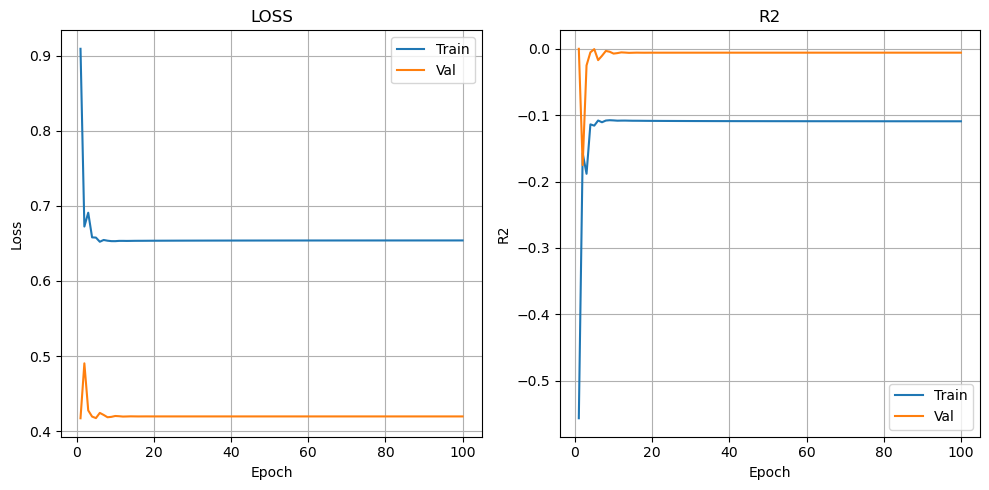

In [139]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

THRESHOLD=100
fg,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1,EPOCH+1),loss[0], label='Train')
axes[0].plot(range(1,EPOCH+1),loss[1], label='Val')
axes[0].grid()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title("LOSS")

axes[1].plot(range(1,THRESHOLD+1),r2[0], label='Train')
axes[1].plot(range(1,THRESHOLD+1),r2[1], label='Val')
axes[1].grid()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2')
axes[1].legend()
axes[1].set_title("R2")
plt.tight_layout()
plt.show()